In this notebook, we will try a new idea for image compression applying to the MNIST dataset. Since the MMD method used the results of the KMeans Clustering and this methods does not work well, we will try to improve the quality of the clusters then the compression rate.


The main idea that we want to expriment here is that, since we already have the labels, there is no need to fit a clustering algorithme to the whole dataset. However, we will apply a clustering algorithm to each subset corresponding to each class of the dataset.

Another remark is that, the MMD method (and all other set redundancy method) will produce a (some) new image(s) for each set, that why sometimes we can't reduce the size of the compressed images. So we will not create a new image but use an element of the image set as the reference and try to reduce the information of all other images in that set with respect to the reference.

Also, the hypothesis that all images are similar in the same set is quite restricted in real life data. So, an idea to deal with this issue is that we can reduce the number of images in each set. And in each set, we just compresse the set without producing some new images, we hope that this can reduce dramatically the size.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Data Loading

In [2]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Transformation applied on each image
transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

train_dataset = MNIST(root='./MNIST', train=True, transform = None, download=True)

c:\Users\nguye\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The MNIST dataset has 10 classes

In [3]:
n_classes = 10
n_images = 60000

We store the images and its labels 

In [4]:
X = []
labels = []
for k in range(60000):
    X.append(np.array(train_dataset[k][0]))
    labels.append(np.array(train_dataset[k][1]))
X = np.array(X)
labels = np.array(labels)

## Visualization of images in the same class

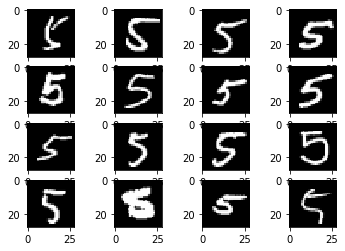

In [5]:
fig, axs = plt.subplots(4,4)
axs = axs.ravel()
idx = np.random.choice(np.where(labels == 5)[0], size = 16)

for k in range(len(axs)):
    axs[k].imshow(X[idx[k]], cmap = 'gray')

# TEST FOR MNIST

In [9]:
n_test = 10000
id_test = np.random.choice(range(n_images), n_test)
X_test = X[id_test,:,:]
X_test_flatten = X_test.reshape((n_test, -1))

In [27]:
X_fatten = X.reshape((60000, -1))

In [12]:
import glob

## MNIST

In [42]:
mnist_full = 54880032

In [17]:
mnist = 54880032 / 6.
mnist

9146672.0

## Only PNG

In [14]:
path = "./MNIST/Compressed_test/png/"

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_test[k])

In [18]:
size = 0
for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)
png = mnist / size
print(png)

3427178
2.668864004145685


## Delta + PNG

In [19]:
def Delta_Encoder(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[:,1:,:] = X[:,1:,:] - X[:,:-1,:]

    return Y 

In [20]:
path = "./MNIST/Compressed_test/delta_png/"

X_test_delta = Delta_Encoder(X_test)

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_test_delta[k])

size = 0
for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

print(size)
delta_png = mnist / size
print(delta_png)

3720176
2.4586664716938125


## MMD

## Clusters

In [30]:
cluster_path = "./Clusters/MNIST/*.npy"   # Path to all .npy files
clusters = {}
for f in glob.glob(cluster_path):
    clusters[f[17:24]] = np.load(f)

clusters

{'MNIST10': array([8, 6, 2, ..., 8, 4, 9]),
 'MNIST20': array([17, 11, 13, ..., 10,  6,  8]),
 'MNIST30': array([25,  7, 16, ..., 25, 17, 15]),
 'MNIST40': array([17, 39, 38, ..., 17, 16, 23]),
 'MNIST50': array([31, 21, 43, ..., 29, 27, 36]),
 'MNIST60': array([48, 50,  5, ..., 26, 14, 52]),
 'MNIST70': array([17, 65, 59, ..., 17, 44, 35]),
 'MNIST80': array([63,  6, 74, ..., 25, 50, 31]),
 'MNIST90': array([52, 39, 46, ..., 52, 21, 75])}

In [23]:

def MMD_Encoder(X):
    '''
    Min Max Differential
    X : input images, of shape (N, ), if not it will be reshaped

    return: Y - encoded images of the same shape as X
            min_im, max_im as arrays
    '''
    N = X.shape[0]
    X = X.reshape((N, -1))

    min_im = np.min(X, axis=0)
    max_im = np.max(X, axis=0)

    Y = np.zeros(X.shape)
    Y[:, 0] = X[:,0] - min_im[0]
    dis = (X[:,:-1] - min_im[:-1]) < (X[:,:-1] - max_im[:-1])
    Y[:,1:] = (X[:,1:] - min_im[1:])*dis + (max_im[1:] - X[:,1:])*(~dis)

    Y = np.reshape(Y, (N, 28, 28))
    min_im = np.reshape(min_im, (28, 28))
    max_im = np.reshape(max_im, (28, 28))

    return Y, min_im, max_im  

### MMD 

In [21]:
def Delta_Encoder_Single(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[1:,:] = X[1:,:] - X[:-1,:]

    return Y 

In [31]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\mmd_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [32]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, min, max = MMD_Encoder(image_set)

        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\mmd_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [43]:
mmd = []
for name in clusters:
    path = ".\MNIST\Compressed_test\mmd_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    mmd.append(size)
    # np.save("./Saved_datas/mmd_flatten_" + name + "_png_size.npy", size)

mmd = np.array(mmd)
mmd = mnist_full / mmd

25610491
25662592
25897873
25901154
25939523
25987355
26028816
26041254
26045724


In [44]:
print(mmd)

[2.14287309 2.13852256 2.11909418 2.11882575 2.11569164 2.11179753
 2.10843367 2.10742662 2.10706494]


### MMD + Delta

In [35]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\mmd_delta_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [36]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, min, max = MMD_Encoder(image_set)
        
        compressed_set = Delta_Encoder(compressed_set)
        min = Delta_Encoder_Single(min)
        max = Delta_Encoder_Single(max)

        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\mmd_delta_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [45]:
mmd_delta = []
for name in clusters:
    path = ".\MNIST\Compressed_test\mmd_delta_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    mmd_delta.append(size)
    # np.save("./Saved_datas/mmd_flatten_" + name + "_png_size.npy", size)

mmd_delta = np.array(mmd_delta)
mmd_delta = mnist_full / mmd_delta
print(mmd_delta)

20539030
20639835
20780358
20813867
20947599
20978711
20997463
21069796
21054138
[2.67198753 2.65893754 2.640957   2.63670523 2.61987219 2.61598684
 2.61365061 2.6046779  2.606615  ]


### Delta + MMD

In [39]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\delta_mmd_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [40]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        image_set = Delta_Encoder(image_set)
        compressed_set, min, max = MMD_Encoder(image_set)


        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\delta_mmd_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [46]:
delta_mmd = []
for name in clusters:
    path = ".\MNIST\Compressed_test\delta_mmd_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    delta_mmd.append(size)
    # np.save("./Saved_datas/mmd_flatten_" + name + "_png_size.npy", size)

delta_mmd = np.array(delta_mmd)
delta_mmd = mnist_full / delta_mmd
print(delta_mmd)

27142816
27309260
27583021
27596298
27660796
27658357
27720585
27721277
27722869
[2.02189898 2.00957595 1.98963094 1.9886737  1.98403661 1.98421157
 1.97975735 1.97970793 1.97959425]


In [47]:
print(png)
print(delta_png)
print(mmd)
print(mmd_delta)
print(delta_mmd)

2.668864004145685
2.4586664716938125
[2.14287309 2.13852256 2.11909418 2.11882575 2.11569164 2.11179753
 2.10843367 2.10742662 2.10706494]
[2.67198753 2.65893754 2.640957   2.63670523 2.61987219 2.61598684
 2.61365061 2.6046779  2.606615  ]
[2.02189898 2.00957595 1.98963094 1.9886737  1.98403661 1.98421157
 1.97975735 1.97970793 1.97959425]


In [48]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

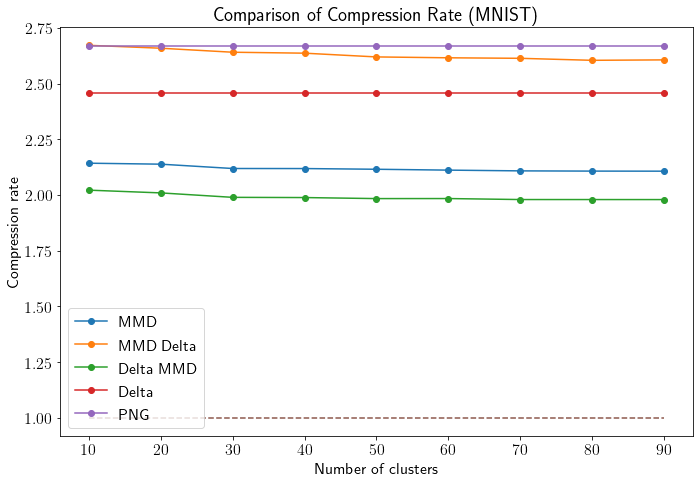

In [50]:
n_clusters = np.arange(10, 91, 10)
x = np.ones(len(n_clusters))
plt.figure(figsize=(10,7))
plt.plot(n_clusters, mmd, "-o", label = "MMD")
plt.plot(n_clusters, mmd_delta, "-o", label = "MMD Delta")
plt.plot(n_clusters, delta_mmd, "-o", label = "Delta MMD")
plt.plot(n_clusters, delta_png * x, "-o", label = "Delta")
plt.plot(n_clusters, png * x, "-o", label = "PNG")
plt.plot(n_clusters, x, "--")
plt.title("Comparison of Compression Rate (MNIST)")
plt.xlabel("Number of clusters")
plt.ylabel("Compression rate")
plt.legend(loc = 3)
plt.tight_layout()
plt.savefig("./Image/rate_mmd_mnist.pdf")
plt.show()

### K-NN 

In [53]:
from sklearn.neighbors import NearestNeighbors

In [55]:
path = "./MNIST/Compressed_test/knn_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_test_flatten)
idx = NN.kneighbors(X_test_flatten, n_neighbors = 2, return_distance = False)[:,1]

X_nn = X_test - X_test[idx,:,:]

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_nn[k])

In [56]:
size = 0
path = "./MNIST/Compressed_test/knn_png/"

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

knn = mnist / size
print(size)
print(knn)

3469298
2.6364619009378845


## KNN + Delta

In [57]:

path = "./MNIST/Compressed_test/knn_delta_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_test_flatten)
idx = NN.kneighbors(X_test_flatten, n_neighbors = 2, return_distance = False)[:,1]

X_nn = X_test - X_test[idx,:,:]
X_nn = Delta_Encoder(X_nn)

for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_nn[k])
    
size = 0

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

knn_delta = mnist / size
print(size)
print(knn_delta)

3737197
2.447468517180122


### Delta + KNN

In [58]:

path = "./MNIST/Compressed_test/delta_knn_png/"

NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
X_delta = Delta_Encoder(X_test).reshape((n_test, -1))
NN.fit(X_delta)
idx = NN.kneighbors(X_delta, n_neighbors = 2, return_distance = False)[:,1]

X_nn = X_test - X_test[idx,:,:]


for k in range(n_test):
    cv2.imwrite(path + str(k) + ".png", X_nn[k])
    
size = 0

for f in glob.glob(path + "*.png"):
    size = size + os.path.getsize(f)

delta_knn = mnist / size
print(size)
print(delta_knn)

3405914
2.6855264108254056


In [59]:
print(png)
print(knn)
print(knn_delta)
print(delta_png)
print(delta_knn)

2.668864004145685
2.6364619009378845
2.447468517180122
2.4586664716938125
2.6855264108254056


In [60]:
results = {"PNG" : png, "K-NN": knn, "K-NN Delta": knn_delta, "Delta": delta_png, "Delta k-NN": delta_knn}

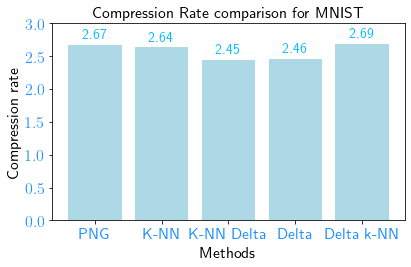

In [63]:
# Choose the height of the bars
height = np.array(list(results.values())).squeeze()

# Choose the names of the bars
bars = list(results.keys())
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color = "lightblue")

# Create names on the x-axis
plt.xticks(x_pos, bars, color = "dodgerblue")
plt.yticks(color = "dodgerblue")

for i in range(len(bars)):
    plt.text(x = x_pos[i] - 0.2 , y = height[i] + 0.1, s = np.round(height[i], 2), size = 14, color = "deepskyblue")

plt.ylim([0, 3])
plt.ylabel("Compression rate", fontsize = 16)
plt.xlabel("Methods", fontsize = 16)
plt.title("Compression Rate comparison for MNIST", fontsize = 16)

# Show graphic
plt.tight_layout()
plt.savefig("./Image/Rate_KNN_MNIST.pdf")
plt.show()

# MMP

In [67]:
import skimage.measure as skm

In [69]:
def image_encoder(I, Imin, Imax, m = 20, block_size = (2,2)):
    '''
    Image encoder of min max predictive method
    Input:  I - image of shape (H, W, 3)

    Return: encoded_image : numpy array of the same shape as channel
            level_image : numpy array of shape image.shape / block_size (by each dim)
    '''
    encoded_image = np.zeros(I.shape)
    level_image = m*(I - Imin)/(Imax - Imin)
    level_image = level_image.astype(int)
    level_image = skm.block_reduce(level_image, block_size = block_size, func = np.min)
    I_hat = Imin + np.floor(np.kron(level_image, np.ones(block_size))*(Imax - Imin)/m)
    encoded_image = I - I_hat

    return encoded_image, level_image

def MMP_Encoder(X, m = 20, block_size = (2,2)):
    '''
    Min Max Predictive Encoder
    Input: X - numpy array of shape (N, H, W, C)
       block_size - block size used in predictive level
       m - number of levels 
    Return: Y - numpy array of shape (N, H, W, C), difference between predictive images and original images
    L - numpy array of shape (N, H/block_size, W/block_size, C) containing the levels  
    Imin
    Imax
    '''
    N = X.shape[0]
    Y = []
    L = []
    Imin = np.min(X, axis=0)
    Imax = np.max(X, axis=0)

    for i in range(N):
        Yi, Li = image_encoder(X[i], Imin, Imax, m = m, block_size=block_size)
        Y.append(Yi)
        L.append(Li)

    return np.array(Y), np.array(L), Imin, Imax

## MMP

In [65]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\mmp_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [70]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, level, min, max = MMP_Encoder(image_set)

        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\mmp_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        np.save(path + "level" + str(value) + ".npy", level)
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10


c:\Users\nguye\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [71]:
mmp = []
for name in clusters:
    path = ".\MNIST\Compressed_test\mmp_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    mmp.append(size)
    # np.save("./Saved_datas/mmp_flatten_" + name + "_png_size.npy", size)

mmp = np.array(mmp)
mmp = mnist_full / mmp
print(mmp)

21132233
21186912
21188677
21263893
21288939
21318919
21372152
21375336
21414952
[2.59698216 2.59027989 2.59006412 2.58090238 2.577866   2.57424084
 2.56782901 2.56744652 2.56269694]


### MMP + Delta

In [72]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\mmp_delta_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [73]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        compressed_set, level, min, max = MMP_Encoder(image_set)
        
        compressed_set = Delta_Encoder(compressed_set)
        min = Delta_Encoder_Single(min)
        max = Delta_Encoder_Single(max)

        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\mmp_delta_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        np.save(path + "level" + str(value) + ".npy", level)
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10


c:\Users\nguye\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [74]:
mmp_delta = []
for name in clusters:
    path = ".\MNIST\Compressed_test\mmp_delta_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    mmp_delta.append(size)
    # np.save("./Saved_datas/mmd_flatten_" + name + "_png_size.npy", size)

mmp_delta = np.array(mmp_delta)
mmp_delta = mnist_full / mmp_delta
print(mmp_delta)

17092072
17175420
17084258
17152918
17165940
17140086
17216632
17246141
17252767
[3.21084723 3.19526579 3.21231581 3.19945749 3.1970304  3.20185278
 3.18761718 3.18216301 3.18094089]


### Delta + MMP

In [75]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):

        path = ".\MNIST\Compressed_test\delta_mmp_png\ " + name  + "\ "

        if os.path.exists(path):
            # os.rmdir(path)
            files = glob.glob(path + '*')
            for f in files:
                os.remove(f)
        else:
            os.mkdir(path)

MNIST10
MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [76]:
for name, cluster in clusters.items():
    print(name)
    for value in np.unique(cluster):
        image_set = X[cluster == value]
        image_set = Delta_Encoder(image_set)
        compressed_set, level, min, max = MMP_Encoder(image_set)


        # print(min.max(), max.min())
        # os.chdir(path)
        path = ".\MNIST\Compressed_test\delta_mmp_png\ " + name  + "\ "

        for i in range(compressed_set.shape[0]):
            cv2.imwrite(path + "cluster" + str(value) + 'im' + str(i) + ".png", compressed_set[i].reshape((28,28)))
        
        np.save(path + "level" + str(value) + ".npy", level)
        cv2.imwrite(path + "min" + str(value) + ".png", min.reshape((28, 28)))
        cv2.imwrite(path + "max" + str(value) + ".png", max.reshape((28, 28)))


MNIST10


c:\Users\nguye\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


MNIST20
MNIST30
MNIST40
MNIST50
MNIST60
MNIST70
MNIST80
MNIST90


In [77]:
delta_mmp = []
for name in clusters:
    path = ".\MNIST\Compressed_test\delta_mmp_png\ " + name  + "\ "

    size = 0
    for f in glob.glob(path + "*.png"):
        size = size + os.path.getsize(f)
    
    print(size)
    delta_mmp.append(size)
    # np.save("./Saved_datas/mmd_flatten_" + name + "_png_size.npy", size)

delta_mmp = np.array(delta_mmp)
delta_mmp = mnist_full / delta_mmp
print(delta_mmp)

22726261
22772751
22747621
22780497
22808165
22798165
22861758
22873145
22885658
[2.41482891 2.40989909 2.41256138 2.40907966 2.40615727 2.40721269
 2.40051671 2.39932165 2.39800979]


In [78]:
print(png)
print(delta_png)
print(mmp)
print(mmp_delta)
print(delta_mmp)

2.668864004145685
2.4586664716938125
[2.59698216 2.59027989 2.59006412 2.58090238 2.577866   2.57424084
 2.56782901 2.56744652 2.56269694]
[3.21084723 3.19526579 3.21231581 3.19945749 3.1970304  3.20185278
 3.18761718 3.18216301 3.18094089]
[2.41482891 2.40989909 2.41256138 2.40907966 2.40615727 2.40721269
 2.40051671 2.39932165 2.39800979]


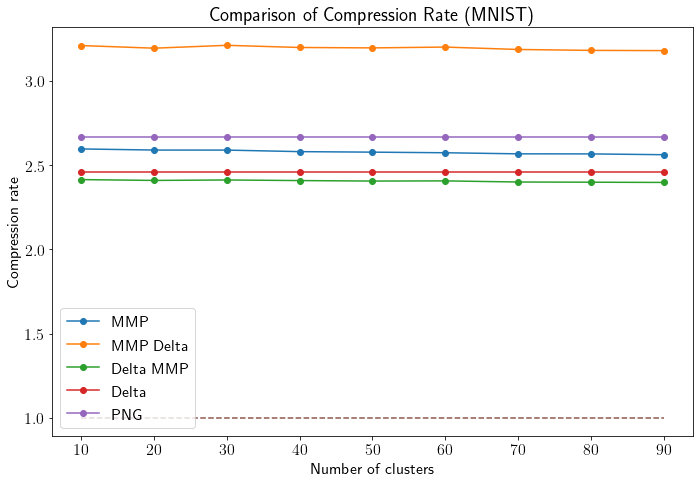

In [79]:
n_clusters = np.arange(10, 91, 10)
x = np.ones(len(n_clusters))
plt.figure(figsize=(10,7))
plt.plot(n_clusters, mmp, "-o", label = "MMP")
plt.plot(n_clusters, mmp_delta, "-o", label = "MMP Delta")
plt.plot(n_clusters, delta_mmp, "-o", label = "Delta MMP")
plt.plot(n_clusters, delta_png * x, "-o", label = "Delta")
plt.plot(n_clusters, png * x, "-o", label = "PNG")
plt.plot(n_clusters, x, "--")
plt.title("Comparison of Compression Rate (MNIST)")
plt.xlabel("Number of clusters")
plt.ylabel("Compression rate")
plt.legend(loc = 3)
plt.tight_layout()
plt.savefig("./Image/rate_mmp_mnist.pdf")
plt.show()

# VISUALISATiON

In [86]:
id = 5

In [87]:
clusters["MNIST50"]
image_set = X[clusters["MNIST50"] == clusters["MNIST50"][id]]
image_set = Delta_Encoder(image_set)
compressed_set, min, max = MMD_Encoder(image_set)

path = ".\Image\MMD\ "

cv2.imwrite(path + "org.png", X[id].reshape((28,28)))
cv2.imwrite(path + "delta_mmd_mnist.png", compressed_set[id].reshape((28,28)))

True

In [96]:
image_set = X[clusters["MNIST50"] == clusters["MNIST50"][id]]
compressed_set, min, max = MMD_Encoder(image_set)
# compressed_set = Delta_Encoder(compressed_set)

path = ".\Image\MMD\ "

# cv2.imwrite(path + "org.png", X[id].reshape((28,28)))
cv2.imwrite(path + "mmd_mnist.png", compressed_set[id].reshape((28,28)))

True

In [89]:
cv2.imwrite(path + "delta_mnist.png", Delta_Encoder_Single(X[id]))

True

In [95]:
NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten)

nb = NN.kneighbors(X_fatten[id:id+1], n_neighbors = 2, return_distance = False)[:,1]

cv2.imwrite(path + "knn_mnist.png", (X[id] - X[nb]).reshape((28,28)))

True

In [97]:
NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
NN.fit(X_fatten)

nb = NN.kneighbors(X_fatten[id:id+1], n_neighbors = 2, return_distance = False)[:,1]

cv2.imwrite(path + "knn_delta_mnist.png", Delta_Encoder_Single((X[id] - X[nb]).reshape((28,28))))

True

In [98]:
NN = NearestNeighbors(n_neighbors = 2, n_jobs = -1, p = 2)
X_delta = Delta_Encoder(X)
X_delta_flatten = X_delta.reshape((60000, -1))

NN.fit(X_delta_flatten)

nb = NN.kneighbors(X_delta_flatten[id:id+1], n_neighbors = 2, return_distance = False)[:,1]

cv2.imwrite(path + "delta_knn_mnist.png", (X_delta [id] - X_delta [nb]).reshape((28,28)))

True

In [ ]:
id = 5

In [99]:
clusters["MNIST50"]
image_set = X[clusters["MNIST50"] == clusters["MNIST50"][id]]
image_set = Delta_Encoder(image_set)
compressed_set, level, min, max = MMP_Encoder(image_set)

path = ".\Image\MMD\ "

cv2.imwrite(path + "org.png", X[id].reshape((28,28)))
cv2.imwrite(path + "delta_mmp_mnist.png", compressed_set[id].reshape((28,28)))

c:\Users\nguye\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


True

In [101]:
image_set = X[clusters["MNIST50"] == clusters["MNIST50"][id]]
compressed_set, level, min, max = MMP_Encoder(image_set)
compressed_set = Delta_Encoder(compressed_set)

path = ".\Image\MMD\ "

# cv2.imwrite(path + "org.png", X[id].reshape((28,28)))
cv2.imwrite(path + "mmp_delta_mnist.png", compressed_set[id].reshape((28,28)))

c:\Users\nguye\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


True

In [102]:
1/6

0.16666666666666666

## Apply to the whole dataset

We will calculate the distances for all images in the whole dataset, and we will divide them into several subset in which the distance is minimal.

In [5]:
from sklearn.neighbors import NearestNeighbors

In [6]:
X_fatten = X.reshape((n_images, -1))

### With 2 images in each set

In [7]:
NN = NearestNeighbors(n_jobs = -1, p = 1)
NN.fit(X_fatten)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=1, radius=1.0)

Define image sets index:      

An array of shape (n_images / n_neighbors, n_neighbors), each row contains the indexes of images in each image set

In [61]:
NN.kneighbors(X_fatten[10:11,], n_neighbors = 2, return_distance = False)

array([[    0, 32248]], dtype=int64)

In [63]:
NN_X_2.kneighbors(X_fatten[32248:32249,],  n_neighbors = 2, return_distance = False)

array([[32248, 46358]], dtype=int64)

In [ ]:
NN_X_2.kneighbors(X_fatten[32248:32249,],  n_neighbors = 2, return_distance = False)

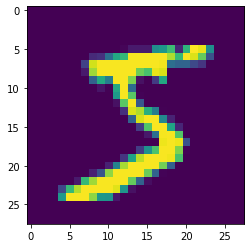

In [65]:
plt.imshow(X[0])

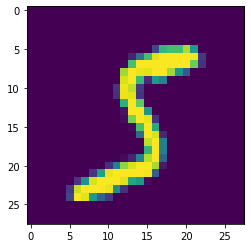

In [66]:
plt.imshow(X[32248])

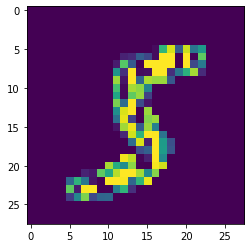

In [69]:
plt.imshow(np.abs(X[46358] - X[32248]))

In [51]:
cv2.imwrite("org.png", X[0])
cv2.imwrite("diff.png", np.abs(X[0] - X[32248]))


True

In [32]:
np.save("org.npy", X[32248])
np.save("diff.npy", X[32248] - X[0]) 

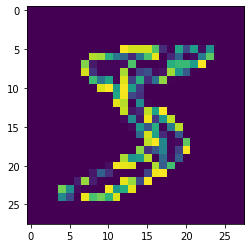

In [52]:
plt.imshow(np.abs(X[32248] - X[0]))

### Combine with Delta Encoder

In [47]:
def Delta_Encoder_Single(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[1:,:] = X[1:,:] - X[:-1,:]

    return Y 

In [35]:
def Delta_Encoder(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[:,1:,:] = X[:,1:,:] - X[:,:-1,:]

    return Y 

In [36]:
X_delta = Delta_Encoder(X)


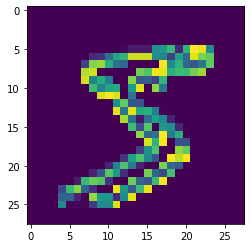

In [37]:
plt.imshow(X_delta[0])

In [39]:
X_delta_flatten = X_delta.reshape((n_images, -1))

In [40]:
NN_X_delta_2 = NearestNeighbors(n_neighbors = 2, n_jobs = -1)
NN_X_delta_2.fit(X_delta_flatten)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=2, p=2, radius=1.0)

In [42]:
NN_X_delta_2.kneighbors(X_delta_flatten[0:1], n_neighbors = 2, return_distance= False)

array([[    0, 52057]], dtype=int64)

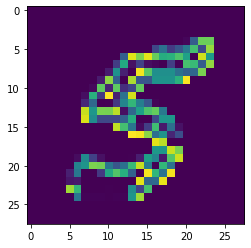

In [43]:
plt.imshow(X_delta[52057])

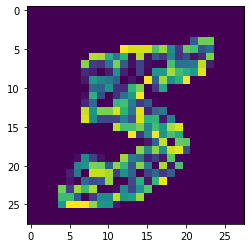

In [44]:
plt.imshow(X_delta[52057] -  X_delta[0])

In [45]:
cv2.imwrite("org.png", X_delta[52057])
cv2.imwrite("diff.png", X_delta[52057] - X_delta[0])


True